Number of images in Normal class: 1589
Number of images in Osteoarthritis class: 2257


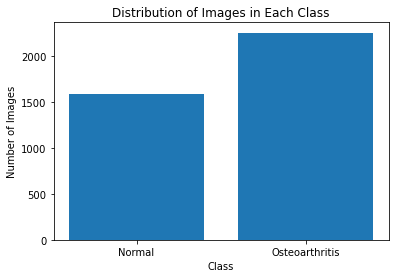

In [1]:
import os
import cv2
import matplotlib.pyplot as plt

def load_and_resize_images_from_folder(folder, target_size=(224, 224)):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, target_size)
            images.append(img)
    return images

# Load images from directories for each class
normal_images = load_and_resize_images_from_folder('/home/lab5/ML4/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Normal')
osteoarthritis_images = load_and_resize_images_from_folder('/home/lab5/ML4/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Osteoarthritis')

# Display the number of images in each class
print("Number of images in Normal class:", len(normal_images))
print("Number of images in Osteoarthritis class:", len(osteoarthritis_images))

# Create a histogram to visualize the distribution of images in each class
plt.bar(['Normal', 'Osteoarthritis'], [len(normal_images), len(osteoarthritis_images)])
plt.title('Distribution of Images in Each Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


2024-03-22 17:02:19.030380: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-22 17:02:19.031532: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-22 17:02:19.092679: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-22 17:02:19.331018: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-22 17:02:19.930104: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

Number of images in Normal class: 1589
Number of images in Osteoarthritis class: 2257
Number of images in Normal class after augmentation: 2257


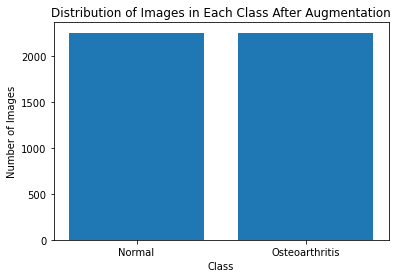

In [2]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define a function to load and resize images from a folder
def load_and_resize_images_from_folder(folder, target_size=(224, 224)):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, target_size)
            images.append(img)
    return images

# Load images from directories for each class
normal_images = load_and_resize_images_from_folder('/home/lab5/ML4/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Normal')
osteoarthritis_images = load_and_resize_images_from_folder('/home/lab5/ML4/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Osteoarthritis')

# Display the number of images in each class
print("Number of images in Normal class:", len(normal_images))
print("Number of images in Osteoarthritis class:", len(osteoarthritis_images))

# Check if data augmentation is needed
if len(normal_images) < len(osteoarthritis_images):
    # Calculate the number of additional images needed
    num_additional_images = len(osteoarthritis_images) - len(normal_images)

    # Create an ImageDataGenerator for data augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Choose random indices from the "Normal" class for augmentation
    sampled_indices = np.random.randint(0, len(normal_images), size=num_additional_images)

    # Perform data augmentation and append augmented images to the "Normal" class
    for index in sampled_indices:
        img = normal_images[index]
        img = img.reshape((1,) + img.shape)  # Reshape for flow() function
        for batch in datagen.flow(img, batch_size=1):
            normal_images.append(batch[0])  # Append augmented images
            break  # Exit the loop after one iteration of data augmentation

    # Display the number of images in the "Normal" class after augmentation
    print("Number of images in Normal class after augmentation:", len(normal_images))

# Create a histogram to visualize the distribution of images in each class after augmentation
plt.bar(['Normal', 'Osteoarthritis'], [len(normal_images), len(osteoarthritis_images)])
plt.title('Distribution of Images in Each Class After Augmentation')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


In [3]:
import random

# Set a seed for reproducibility
random.seed(42)

# Randomly select 1000 images from each class
selected_normal_images = random.sample(normal_images, 1000)
selected_osteoarthritis_images = random.sample(osteoarthritis_images, 1000)

# Combine selected images from both classes
selected_images = selected_normal_images + selected_osteoarthritis_images
labels = [0] * 1000 + [1] * 1000  # Assign labels (0 for Normal, 1 for Osteoarthritis)

# Split the selected images and labels into train and test sets (70:30 ratio)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(selected_images, labels, test_size=0.3, random_state=42)

# Split the train set into train and validation sets (80:20 ratio)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Print the sizes of train, test, and validation sets
print("X_train size:", len(X_train))
print("X_test size:", len(X_test))
print("X_validation size:", len(X_val))


X_train size: 1120
X_test size: 600
X_validation size: 280


# MobileNet+Dense

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (224, 224, 3)

# Load MobileNet pre-trained on ImageNet without including the top (classification) layer
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add a global average pooling layer
x = GlobalAveragePooling2D()(base_model.output)

# Add a fully connected layer with 256 neurons
x = Dense(256, activation='relu')(x)

# Add the final classification layer with softmax activation
predictions = Dense(2, activation='softmax')(x)  # Assuming 2 classes: 'normal' and 'osteoarthritis'

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

import numpy as np

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

# Preprocess the data
X_train_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_train)
X_val_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_val)
X_test_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_test)

# Convert labels to one-hot encoding
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Convert to one-hot encoding
y_train_categorical = to_categorical(y_train_encoded)
y_val_categorical = to_categorical(y_val_encoded)
y_test_categorical = to_categorical(y_test_encoded)


In [5]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=50, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - accuracy: 0.6243 - loss: 0.9945 - val_accuracy: 0.7821 - val_loss: 0.4309
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 187ms/step - accuracy: 0.8376 - loss: 0.3630 - val_accuracy: 0.7643 - val_loss: 0.4594
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 186ms/step - accuracy: 0.8557 - loss: 0.3119 - val_accuracy: 0.8000 - val_loss: 0.3754
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.8868 - loss: 0.2751 - val_accuracy: 0.8357 - val_loss: 0.3586
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 190ms/step - accuracy: 0.9170 - loss: 0.2073 - val_accuracy: 0.8143 - val_loss: 0.3624
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 190ms/step - accuracy: 0.9239 - loss: 0.2018 - val_accuracy: 0.8000 - val_loss: 0.4591
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 190ms/step - accuracy: 0.9266 - loss: 0.1914 - val_accuracy: 0.8321 - val_loss: 0.3805
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 190ms/step - accuracy: 0.9267 - loss: 0.1722 - val_accuracy: 0.

Validation Loss: 0.3094191253185272
Validation Accuracy: 0.8535714149475098
Test Loss: 0.2768723964691162
Test Accuracy: 0.8999999761581421
Inference Time (Test set): 4.3053343296051025 seconds
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       302
           1       0.92      0.87      0.90       298

    accuracy                           0.90       600
   macro avg       0.90      0.90      0.90       600
weighted avg       0.90      0.90      0.90       600

Confusion Matrix:
[[280  22]
 [ 38 260]]


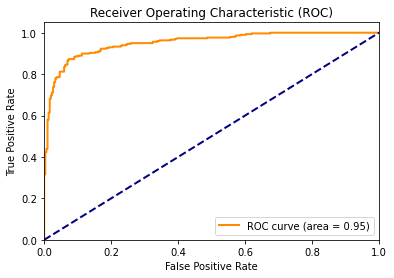

Metrics saved successfully


In [6]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score,cohen_kappa_score,matthews_corrcoef
import pandas as pd
# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

metrics={
    'Combination':'Mobilenet+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('MobileNet_2000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")


In [7]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=100, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 197ms/step - accuracy: 0.9481 - loss: 0.1468 - val_accuracy: 0.8179 - val_loss: 0.4048
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.9434 - loss: 0.1510 - val_accuracy: 0.8393 - val_loss: 0.3317
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.9551 - loss: 0.1160 - val_accuracy: 0.8429 - val_loss: 0.3213
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.9728 - loss: 0.0891 - val_accuracy: 0.8536 - val_loss: 0.3262
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.9750 - loss: 0.0894 - val_accuracy: 0.8321 - val_loss: 0.3646
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.9859 - loss: 0.0620 - val_accuracy: 0.8357 - val_loss: 0.4137
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 193ms/step - accuracy: 0.9822 - loss: 0.0622 - val_accuracy: 0.8464 - val_loss: 0.3711
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 193ms/step - accuracy: 0.9958 - loss: 0.0451 - val_accu

Validation Loss: 0.3212827444076538
Validation Accuracy: 0.8428571224212646
Test Loss: 0.31845149397850037
Test Accuracy: 0.8683333396911621
Inference Time (Test set): 4.307470798492432 seconds
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.96      0.88       302
           1       0.95      0.78      0.85       298

    accuracy                           0.87       600
   macro avg       0.88      0.87      0.87       600
weighted avg       0.88      0.87      0.87       600

Confusion Matrix:
[[289  13]
 [ 66 232]]


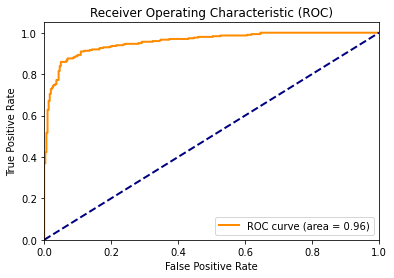

Metrics saved successfully


In [8]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)


# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

metrics={
    'Combination':'Mobilenet+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('MobileNet_2000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")



In [9]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=150, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.9618 - loss: 0.1046 - val_accuracy: 0.7821 - val_loss: 0.5439
Epoch 2/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.9514 - loss: 0.1155 - val_accuracy: 0.8250 - val_loss: 0.4660
Epoch 3/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 193ms/step - accuracy: 0.9706 - loss: 0.0830 - val_accuracy: 0.8250 - val_loss: 0.4001
Epoch 4/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.9838 - loss: 0.0593 - val_accuracy: 0.8429 - val_loss: 0.3274
Epoch 5/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 193ms/step - accuracy: 0.9916 - loss: 0.0520 - val_accuracy: 0.8464 - val_loss: 0.3538
Epoch 6/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.9876 - loss: 0.0610 - val_accuracy: 0.8536 - val_loss: 0.4041
Epoch 7/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.9887 - loss: 0.0554 - val_accuracy: 0.8500 - val_loss: 0.3819
Epoch 8/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.9967 - loss: 0.0258 - val_accu

Validation Loss: 0.3274199068546295
Validation Accuracy: 0.8428571224212646
Test Loss: 0.30365613102912903
Test Accuracy: 0.8833333253860474
Inference Time (Test set): 4.295956134796143 seconds
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.89       302
           1       0.90      0.87      0.88       298

    accuracy                           0.88       600
   macro avg       0.88      0.88      0.88       600
weighted avg       0.88      0.88      0.88       600

Confusion Matrix:
[[272  30]
 [ 40 258]]


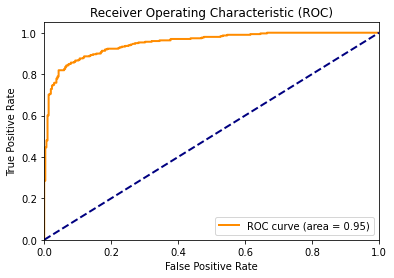

Metrics saved successfully


In [10]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

metrics={
    'Combination':'MObilenet+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('MobileNet_2000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")



In [11]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=200, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.9919 - loss: 0.0604 - val_accuracy: 0.8464 - val_loss: 0.3417
Epoch 2/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.9925 - loss: 0.0550 - val_accuracy: 0.8357 - val_loss: 0.3819
Epoch 3/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 193ms/step - accuracy: 0.9984 - loss: 0.0258 - val_accuracy: 0.8250 - val_loss: 0.5470
Epoch 4/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.9976 - loss: 0.0300 - val_accuracy: 0.8643 - val_loss: 0.3514
Epoch 5/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 193ms/step - accuracy: 0.9997 - loss: 0.0215 - val_accuracy: 0.8571 - val_loss: 0.3423
Epoch 6/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 193ms/step - accuracy: 1.0000 - loss: 0.0165 - val_accuracy: 0.8357 - val_loss: 0.3625
Training Time: 41.021400690078735 seconds


Validation Loss: 0.341653972864151
Validation Accuracy: 0.8464285731315613
Test Loss: 0.2959546148777008
Test Accuracy: 0.8899999856948853
Inference Time (Test set): 4.296535491943359 seconds
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       302
           1       0.89      0.89      0.89       298

    accuracy                           0.89       600
   macro avg       0.89      0.89      0.89       600
weighted avg       0.89      0.89      0.89       600

Confusion Matrix:
[[270  32]
 [ 34 264]]


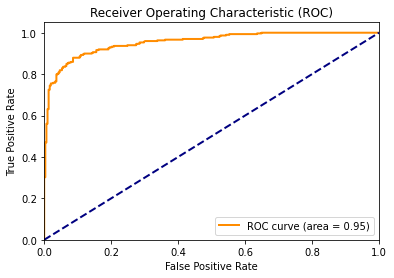

Metrics saved successfully


In [12]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)


metrics={
    'Combination':'Mobilenet+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('MobileNet_2000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")


# MobileNet+Dense+Dropout

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

# Load MobileNet pre-trained on ImageNet without including the top (classification) layer
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add a global average pooling layer
x = GlobalAveragePooling2D()(base_model.output)

# Add a fully connected layer with 256 neurons
x = Dense(256, activation='relu')(x)

# Add dropout regularization
x = Dropout(0.5)(x)  # Adjust dropout rate as needed

# Define the number of output classes based on your data
num_classes = len(np.unique(y_train))

# Add a final classification layer with softmax activation
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Preprocess the data
X_train_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_train)
X_val_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_val)
X_test_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_test)

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Convert to one-hot encoding
from tensorflow.keras.utils import to_categorical
y_train_categorical = to_categorical(y_train_encoded)
y_val_categorical = to_categorical(y_val_encoded)
y_test_categorical = to_categorical(y_test_encoded)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,491,778 (13.32 MB)

 Trainable params: 262,914 (1.00 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [14]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=50, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 205ms/step - accuracy: 0.4629 - loss: 0.7850 - val_accuracy: 0.5321 - val_loss: 0.6914
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 193ms/step - accuracy: 0.5342 - loss: 0.7079 - val_accuracy: 0.5214 - val_loss: 0.7059
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 193ms/step - accuracy: 0.5226 - loss: 0.7142 - val_accuracy: 0.5321 - val_loss: 0.6919
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 193ms/step - accuracy: 0.5057 - loss: 0.7017 - val_accuracy: 0.4786 - val_loss: 0.7147
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.5610 - loss: 0.6845 - val_accuracy: 0.5536 - val_loss: 0.6919
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.5175 - loss: 0.6958 - val_accuracy: 0.5250 - val_loss: 0.6909
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 193ms/step - accuracy: 0.4963 - loss: 0.6941 - val_accuracy: 0.5464 - val_loss: 0.6918
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.5253 - loss: 0.6915 - val_accuracy: 0.

Validation Loss: 0.6909005045890808
Validation Accuracy: 0.5249999761581421
Test Loss: 0.6909491419792175
Test Accuracy: 0.5199999809265137
Inference Time (Test set): 4.381387233734131 seconds
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.98      0.67       302
           1       0.71      0.06      0.11       298

    accuracy                           0.52       600
   macro avg       0.61      0.52      0.39       600
weighted avg       0.61      0.52      0.39       600

Confusion Matrix:
[[295   7]
 [281  17]]


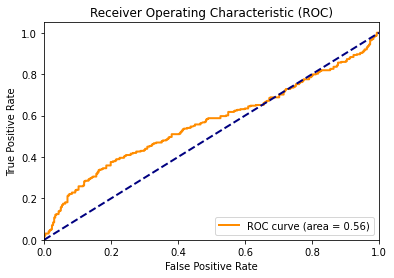

Metrics saved successfully


In [15]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

existing_metrics_df=pd.read_csv('MobileNet_2000_epoch_50_metrics.csv')
metrics={
    'Combination':['MobileNet+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_2000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")


In [16]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=100, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step - accuracy: 0.4989 - loss: 0.6964 - val_accuracy: 0.5643 - val_loss: 0.6915
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.4828 - loss: 0.6957 - val_accuracy: 0.5214 - val_loss: 0.6933
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.4878 - loss: 0.7009 - val_accuracy: 0.5214 - val_loss: 0.6917
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 197ms/step - accuracy: 0.5064 - loss: 0.6961 - val_accuracy: 0.4786 - val_loss: 0.6937
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.5491 - loss: 0.6909 - val_accuracy: 0.4714 - val_loss: 0.6926
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 197ms/step - accuracy: 0.4919 - loss: 0.6940 - val_accuracy: 0.5643 - val_loss: 0.6922
Training Time: 41.65888857841492 seconds


Validation Loss: 0.691533088684082
Validation Accuracy: 0.5642856955528259
Test Loss: 0.6902317404747009
Test Accuracy: 0.5733333230018616
Inference Time (Test set): 4.328075885772705 seconds
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.72      0.63       302
           1       0.60      0.42      0.50       298

    accuracy                           0.57       600
   macro avg       0.58      0.57      0.56       600
weighted avg       0.58      0.57      0.56       600

Confusion Matrix:
[[218  84]
 [172 126]]


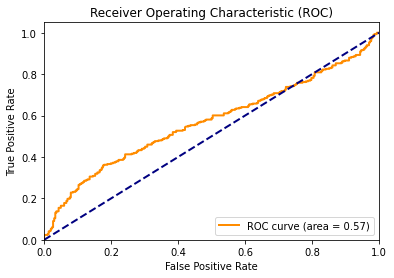

Metrics saved successfully


In [17]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)


# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

existing_metrics_df=pd.read_csv('MobileNet_2000_epoch_100_metrics.csv')
metrics={
    'Combination':['MobileNet+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_2000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")



In [18]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=150, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.5102 - loss: 0.6919 - val_accuracy: 0.4786 - val_loss: 0.6969
Epoch 2/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 192ms/step - accuracy: 0.5372 - loss: 0.6936 - val_accuracy: 0.5214 - val_loss: 0.6912
Epoch 3/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 193ms/step - accuracy: 0.5061 - loss: 0.6924 - val_accuracy: 0.4786 - val_loss: 0.6931
Epoch 4/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 200ms/step - accuracy: 0.5316 - loss: 0.6901 - val_accuracy: 0.5393 - val_loss: 0.6913
Epoch 5/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step - accuracy: 0.5465 - loss: 0.6903 - val_accuracy: 0.4786 - val_loss: 0.6940
Epoch 6/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 193ms/step - accuracy: 0.5107 - loss: 0.6899 - val_accuracy: 0.4786 - val_loss: 0.6926
Epoch 7/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 190ms/step - accuracy: 0.4967 - loss: 0.6967 - val_accuracy: 0.4786 - val_loss: 0.6928
Training Time: 48.03244137763977 seconds


Validation Loss: 0.691201388835907
Validation Accuracy: 0.5214285850524902
Test Loss: 0.692229688167572
Test Accuracy: 0.5066666603088379
Inference Time (Test set): 4.266205310821533 seconds
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.51      1.00      0.67       302
           1       1.00      0.01      0.01       298

    accuracy                           0.51       600
   macro avg       0.75      0.50      0.34       600
weighted avg       0.75      0.51      0.34       600

Confusion Matrix:
[[302   0]
 [296   2]]


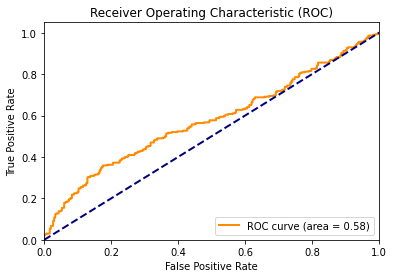

Metrics saved successfully


In [19]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)


# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

existing_metrics_df=pd.read_csv('MobileNet_2000_epoch_150_metrics.csv')
metrics={
    'Combination':['MobileNet+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_2000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")


In [20]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=200, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 193ms/step - accuracy: 0.4854 - loss: 0.6960 - val_accuracy: 0.5179 - val_loss: 0.6915
Epoch 2/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 191ms/step - accuracy: 0.5250 - loss: 0.6905 - val_accuracy: 0.4786 - val_loss: 0.6939
Epoch 3/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 190ms/step - accuracy: 0.5063 - loss: 0.6942 - val_accuracy: 0.5571 - val_loss: 0.6920
Epoch 4/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 190ms/step - accuracy: 0.5212 - loss: 0.6915 - val_accuracy: 0.4786 - val_loss: 0.6933
Epoch 5/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 190ms/step - accuracy: 0.5285 - loss: 0.6909 - val_accuracy: 0.4679 - val_loss: 0.6924
Epoch 6/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 191ms/step - accuracy: 0.5159 - loss: 0.6935 - val_accuracy: 0.5143 - val_loss: 0.6922
Training Time: 40.30295991897583 seconds


Validation Loss: 0.6914666295051575
Validation Accuracy: 0.5178571343421936
Test Loss: 0.6929064393043518
Test Accuracy: 0.5049999952316284
Inference Time (Test set): 4.4447736740112305 seconds
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       302
           1       1.00      0.00      0.01       298

    accuracy                           0.51       600
   macro avg       0.75      0.50      0.34       600
weighted avg       0.75      0.51      0.34       600

Confusion Matrix:
[[302   0]
 [297   1]]


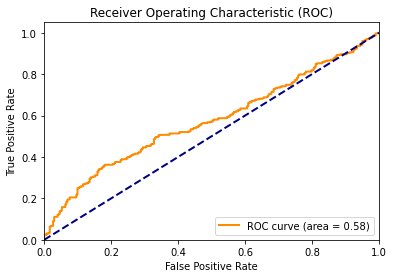

Metrics saved successfully


In [21]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

existing_metrics_df=pd.read_csv('MobileNet_2000_epoch_200_metrics.csv')
metrics={
    'Combination':['MobileNet+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_2000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# MobileNet+Conv2D+GlobalAveragePooling+Dropout+Dense

In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Conv2D, Dropout
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (224, 224, 3)

# Load MobileNet pre-trained on ImageNet without including the top (classification) layer
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add a Conv2D layer
x = Conv2D(64, (3, 3), activation='relu', padding='same')(base_model.output)

# Add a global average pooling layer
x = GlobalAveragePooling2D()(x)

# Add a dropout layer
x = Dropout(0.5)(x)

# Add a fully connected layer with 256 neurons
x = Dense(256, activation='relu')(x)

# Add the final classification layer with softmax activation
predictions = Dense(2, activation='softmax')(x)  # Assuming 2 classes: 'normal' and 'osteoarthritis'

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Preprocess the data
X_train_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_train)
X_val_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_val)
X_test_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_test)

# Convert labels to one-hot encoding
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Convert to one-hot encoding
y_train_categorical = to_categorical(y_train_encoded)
y_val_categorical = to_categorical(y_val_encoded)
y_test_categorical = to_categorical(y_test_encoded)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,835,906 (14.63 MB)

 Trainable params: 607,042 (2.32 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [23]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=50, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 210ms/step - accuracy: 0.5231 - loss: 0.7344 - val_accuracy: 0.5214 - val_loss: 0.6936
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.4981 - loss: 0.6987 - val_accuracy: 0.5214 - val_loss: 0.6926
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.4751 - loss: 0.6991 - val_accuracy: 0.4786 - val_loss: 0.6938
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.5037 - loss: 0.6956 - val_accuracy: 0.4786 - val_loss: 0.6950
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.5194 - loss: 0.6925 - val_accuracy: 0.4786 - val_loss: 0.6935
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.5044 - loss: 0.6934 - val_accuracy: 0.4786 - val_loss: 0.6934
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.5174 - loss: 0.6933 - val_accuracy: 0.4786 - val_loss: 0.6938
Training Time: 49.5254111289978 seconds


Validation Loss: 0.692577064037323
Validation Accuracy: 0.5214285850524902
Test Loss: 0.6932207345962524
Test Accuracy: 0.503333330154419
Inference Time (Test set): 4.338076829910278 seconds
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       302
           1       0.00      0.00      0.00       298

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.34       600

Confusion Matrix:
[[302   0]
 [298   0]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


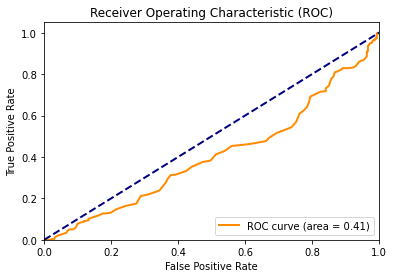

Metrics saved successfully


In [24]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score,cohen_kappa_score,matthews_corrcoef
import pandas as pd

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_2000_epoch_50_metrics.csv')
metrics={
    'Combination':['MobileNet+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_2000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [25]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=100, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 199ms/step - accuracy: 0.4958 - loss: 0.6973 - val_accuracy: 0.5214 - val_loss: 0.6929
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 197ms/step - accuracy: 0.4960 - loss: 0.6934 - val_accuracy: 0.4786 - val_loss: 0.6937
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.5056 - loss: 0.6935 - val_accuracy: 0.4786 - val_loss: 0.6936
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.4978 - loss: 0.6932 - val_accuracy: 0.4786 - val_loss: 0.6941
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.5220 - loss: 0.6928 - val_accuracy: 0.4786 - val_loss: 0.6948
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.5178 - loss: 0.6931 - val_accuracy: 0.5214 - val_loss: 0.6929
Training Time: 41.56135630607605 seconds


Validation Loss: 0.6928547620773315
Validation Accuracy: 0.5214285850524902
Test Loss: 0.6931430697441101
Test Accuracy: 0.503333330154419
Inference Time (Test set): 4.335867166519165 seconds
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       302
           1       0.00      0.00      0.00       298

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.34       600

Confusion Matrix:
[[302   0]
 [298   0]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


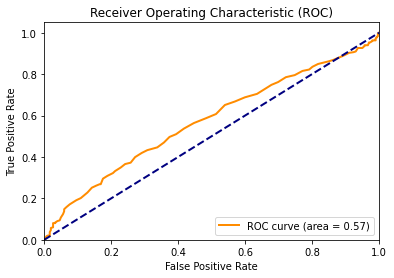

Metrics saved successfully


In [26]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_2000_epoch_100_metrics.csv')
metrics={
    'Combination':['MobileNet+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_2000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [27]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=150, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step - accuracy: 0.4865 - loss: 0.6939 - val_accuracy: 0.4786 - val_loss: 0.6939
Epoch 2/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.4432 - loss: 0.6946 - val_accuracy: 0.4786 - val_loss: 0.6934
Epoch 3/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.5358 - loss: 0.6930 - val_accuracy: 0.4786 - val_loss: 0.6938
Epoch 4/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.5031 - loss: 0.6932 - val_accuracy: 0.4786 - val_loss: 0.6939
Epoch 5/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.5115 - loss: 0.6930 - val_accuracy: 0.4786 - val_loss: 0.6938
Epoch 6/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.5040 - loss: 0.6934 - val_accuracy: 0.4786 - val_loss: 0.6936
Epoch 7/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.5078 - loss: 0.6932 - val_accuracy: 0.4786 - val_loss: 0.6938
Training Time: 48.2771475315094 seconds


Validation Loss: 0.6933726072311401
Validation Accuracy: 0.47857141494750977
Test Loss: 0.6931824088096619
Test Accuracy: 0.49666666984558105
Inference Time (Test set): 4.341079473495483 seconds
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       302
           1       0.50      1.00      0.66       298

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600

Confusion Matrix:
[[  0 302]
 [  0 298]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


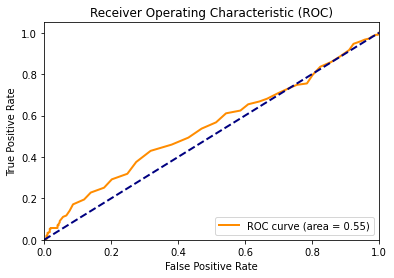

Metrics saved successfully


In [28]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_2000_epoch_150_metrics.csv')
metrics={
    'Combination':['MobileNet+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_2000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [29]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=200, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 199ms/step - accuracy: 0.5097 - loss: 0.6934 - val_accuracy: 0.4786 - val_loss: 0.6940
Epoch 2/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.4976 - loss: 0.6936 - val_accuracy: 0.4786 - val_loss: 0.6942
Epoch 3/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.4784 - loss: 0.6941 - val_accuracy: 0.4786 - val_loss: 0.6943
Epoch 4/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 197ms/step - accuracy: 0.5077 - loss: 0.6932 - val_accuracy: 0.4786 - val_loss: 0.6940
Epoch 5/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.5147 - loss: 0.6928 - val_accuracy: 0.4786 - val_loss: 0.6944
Epoch 6/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 197ms/step - accuracy: 0.5080 - loss: 0.6931 - val_accuracy: 0.4786 - val_loss: 0.6936
Epoch 7/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.5045 - loss: 0.6932 - val_accuracy: 0.4786 - val_loss: 0.6936
Epoch 8/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.5109 - loss: 0.6931 - val_accu

Validation Loss: 0.6935605406761169
Validation Accuracy: 0.47857141494750977
Test Loss: 0.6932266354560852
Test Accuracy: 0.49666666984558105
Inference Time (Test set): 4.368206739425659 seconds
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       302
           1       0.50      1.00      0.66       298

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600

Confusion Matrix:
[[  0 302]
 [  0 298]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


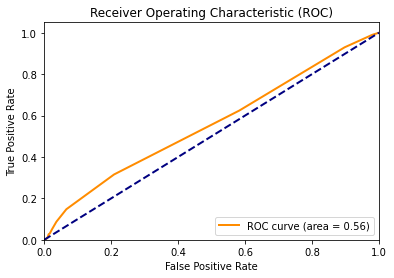

Metrics saved successfully


In [30]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_2000_epoch_200_metrics.csv')
metrics={
    'Combination':['MobileNet+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_2000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# MobileNet+LSTM+Dense

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Reshape
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (224, 224, 3)  # You need to define the input shape

# Load MobileNet pre-trained on ImageNet without including the top (classification) layer
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Flatten the output of the base model
x = Flatten()(base_model.output)

# Reshape the flattened output to include the time steps dimension
x = Reshape((1, -1))(x)  # Assuming each sample represents a single time step

# Add LSTM layer
x = LSTM(128)(x)

# Add a fully connected layer with 256 neurons
x = Dense(256, activation='relu')(x)

# Add the final classification layer with softmax activation
predictions = Dense(2, activation='softmax')(x)  # Assuming num_classes is the number of output classes

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()



import numpy as np

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

# Preprocess the data
X_train_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_train)
X_val_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_val)
X_test_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_test)


# Convert labels to one-hot encoding
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Convert to one-hot encoding
y_train_categorical = to_categorical(y_train_encoded)
y_val_categorical = to_categorical(y_val_encoded)
y_test_categorical = to_categorical(y_test_encoded)


In [6]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=50, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 198ms/step - accuracy: 0.5846 - loss: 1.0158 - val_accuracy: 0.7750 - val_loss: 0.4432
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 186ms/step - accuracy: 0.8366 - loss: 0.3529 - val_accuracy: 0.8000 - val_loss: 0.3884
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 197ms/step - accuracy: 0.8570 - loss: 0.3075 - val_accuracy: 0.8107 - val_loss: 0.3618
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step - accuracy: 0.8797 - loss: 0.2619 - val_accuracy: 0.8250 - val_loss: 0.3619
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.9051 - loss: 0.2338 - val_accuracy: 0.8536 - val_loss: 0.3284
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.9202 - loss: 0.1961 - val_accuracy: 0.8321 - val_loss: 0.3550
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.9044 - loss: 0.2064 - val_accuracy: 0.8393 - val_loss: 0.3303
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 199ms/step - accuracy: 0.9404 - loss: 0.1492 - val_accuracy: 0.

Validation Loss: 0.3131115138530731
Validation Accuracy: 0.8607142567634583
Test Loss: 0.287731409072876
Test Accuracy: 0.8849999904632568
Inference Time (Test set): 4.444183349609375 seconds
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       302
           1       0.92      0.84      0.88       298

    accuracy                           0.89       600
   macro avg       0.89      0.88      0.88       600
weighted avg       0.89      0.89      0.88       600

Confusion Matrix:
[[280  22]
 [ 47 251]]


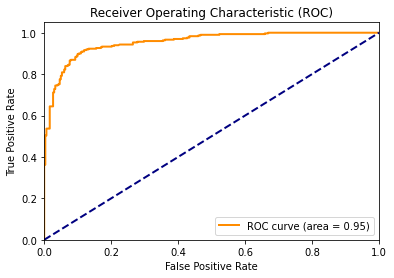

Metrics saved successfully


In [7]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc,cohen_kappa_score,balanced_accuracy_score,matthews_corrcoef
import pandas as pd
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_2000_epoch_50_metrics.csv')
metrics={
    'Combination':['MobileNet+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_2000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [8]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=100, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 199ms/step - accuracy: 0.9919 - loss: 0.0750 - val_accuracy: 0.8464 - val_loss: 0.3254
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.9821 - loss: 0.0644 - val_accuracy: 0.8500 - val_loss: 0.3336
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.9845 - loss: 0.0648 - val_accuracy: 0.8393 - val_loss: 0.3507
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.9903 - loss: 0.0510 - val_accuracy: 0.8393 - val_loss: 0.3499
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.9963 - loss: 0.0400 - val_accuracy: 0.8464 - val_loss: 0.4464
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.9964 - loss: 0.0453 - val_accuracy: 0.8643 - val_loss: 0.3467
Training Time: 41.28468346595764 seconds


Validation Loss: 0.3253915011882782
Validation Accuracy: 0.8464285731315613
Test Loss: 0.28287070989608765
Test Accuracy: 0.8933333158493042
Inference Time (Test set): 4.298120498657227 seconds
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.91      0.90       302
           1       0.91      0.88      0.89       298

    accuracy                           0.89       600
   macro avg       0.89      0.89      0.89       600
weighted avg       0.89      0.89      0.89       600

Confusion Matrix:
[[275  27]
 [ 37 261]]


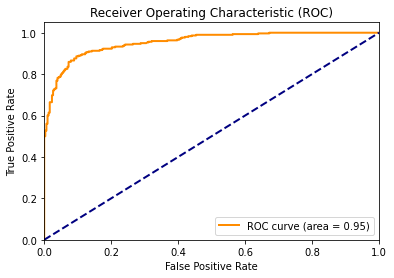

Metrics saved successfully


In [9]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_2000_epoch_100_metrics.csv')
metrics={
    'Combination':['MobileNet+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_2000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [10]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=150, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.9908 - loss: 0.0547 - val_accuracy: 0.8571 - val_loss: 0.3148
Epoch 2/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.9771 - loss: 0.0789 - val_accuracy: 0.8464 - val_loss: 0.3288
Epoch 3/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.9780 - loss: 0.0688 - val_accuracy: 0.8429 - val_loss: 0.4303
Epoch 4/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.9872 - loss: 0.0513 - val_accuracy: 0.8107 - val_loss: 0.5422
Epoch 5/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.9909 - loss: 0.0412 - val_accuracy: 0.8500 - val_loss: 0.3521
Epoch 6/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 1.0000 - loss: 0.0234 - val_accuracy: 0.8536 - val_loss: 0.3889
Training Time: 41.133748054504395 seconds


Validation Loss: 0.3148123025894165
Validation Accuracy: 0.8571428656578064
Test Loss: 0.29307591915130615
Test Accuracy: 0.8816666603088379
Inference Time (Test set): 4.3220484256744385 seconds
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       302
           1       0.90      0.86      0.88       298

    accuracy                           0.88       600
   macro avg       0.88      0.88      0.88       600
weighted avg       0.88      0.88      0.88       600

Confusion Matrix:
[[272  30]
 [ 41 257]]


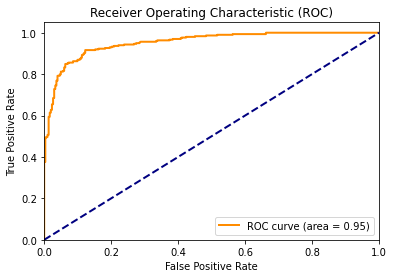

Metrics saved successfully


In [11]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_2000_epoch_150_metrics.csv')
metrics={
    'Combination':['MobileNet+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_2000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [12]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=200, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 199ms/step - accuracy: 0.9825 - loss: 0.0585 - val_accuracy: 0.8286 - val_loss: 0.4675
Epoch 2/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.9660 - loss: 0.0848 - val_accuracy: 0.8357 - val_loss: 0.4446
Epoch 3/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.9963 - loss: 0.0387 - val_accuracy: 0.8679 - val_loss: 0.3238
Epoch 4/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.9922 - loss: 0.0475 - val_accuracy: 0.8321 - val_loss: 0.3730
Epoch 5/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.9962 - loss: 0.0313 - val_accuracy: 0.8571 - val_loss: 0.3655
Epoch 6/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.9995 - loss: 0.0234 - val_accuracy: 0.8393 - val_loss: 0.3766
Epoch 7/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.9993 - loss: 0.0162 - val_accuracy: 0.8607 - val_loss: 0.3616
Epoch 8/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 1.0000 - loss: 0.0166 - val_accu

Validation Loss: 0.3238280713558197
Validation Accuracy: 0.8678571581840515
Test Loss: 0.3334161043167114
Test Accuracy: 0.8883333206176758
Inference Time (Test set): 4.330992221832275 seconds
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       302
           1       0.92      0.85      0.88       298

    accuracy                           0.89       600
   macro avg       0.89      0.89      0.89       600
weighted avg       0.89      0.89      0.89       600

Confusion Matrix:
[[280  22]
 [ 45 253]]


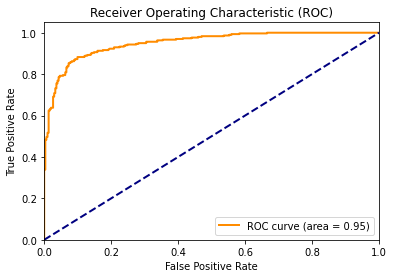

Metrics saved successfully


In [13]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_2000_epoch_200_metrics.csv')
metrics={
    'Combination':['MobileNet+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_2000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# MobileNet+GRU+Dense

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GRU, Flatten, Reshape  # Import Reshape layer
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (224, 224, 3)

# Load MobileNet pre-trained on ImageNet without including the top (classification) layer
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add Flatten layer to convert 4D tensor to 2D tensor
x = Flatten()(base_model.output)

# Reshape the flattened output to have the appropriate shape
x = Reshape((7, 7 * 1024))(x)

# Add GRU layer
x = GRU(128)(x)

# Add a fully connected layer with 256 neurons
x = Dense(256, activation='relu')(x)

# Add the final classification layer with softmax activation
predictions = Dense(2, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


import numpy as np

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

# Preprocess the data
X_train_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_train)
X_val_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_val)
X_test_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_test)

# Convert labels to one-hot encoding
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Convert to one-hot encoding
y_train_categorical = to_categorical(y_train_encoded)
y_val_categorical = to_categorical(y_val_encoded)
y_test_categorical = to_categorical(y_test_encoded)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 6,064,834 (23.14 MB)

 Trainable params: 2,835,970 (10.82 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [19]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=50, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 215ms/step - accuracy: 0.4878 - loss: 0.7981 - val_accuracy: 0.4786 - val_loss: 0.6964
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.5326 - loss: 0.6987 - val_accuracy: 0.4786 - val_loss: 0.7077
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step - accuracy: 0.5637 - loss: 0.6920 - val_accuracy: 0.4786 - val_loss: 0.7169
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 214ms/step - accuracy: 0.4930 - loss: 0.7199 - val_accuracy: 0.4786 - val_loss: 0.7062
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 211ms/step - accuracy: 0.4866 - loss: 0.7098 - val_accuracy: 0.5250 - val_loss: 0.6952
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 208ms/step - accuracy: 0.5205 - loss: 0.7132 - val_accuracy: 0.5214 - val_loss: 0.7041
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 208ms/step - accuracy: 0.5064 - loss: 0.7058 - val_accuracy: 0.4786 - val_loss: 0.7159
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 208ms/step - accuracy: 0.4866 - loss: 0.7060 - val_accuracy: 0.

Validation Loss: 0.6890717148780823
Validation Accuracy: 0.5571428537368774
Test Loss: 0.6836719512939453
Test Accuracy: 0.574999988079071
Inference Time (Test set): 4.379178047180176 seconds
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.86      0.67       302
           1       0.67      0.28      0.40       298

    accuracy                           0.57       600
   macro avg       0.61      0.57      0.53       600
weighted avg       0.61      0.57      0.54       600

Confusion Matrix:
[[261  41]
 [214  84]]


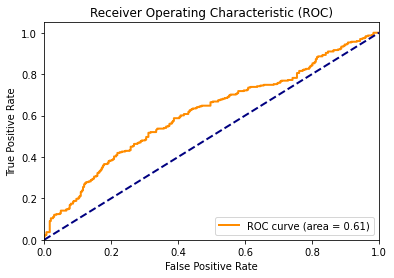

Metrics saved successfully


In [20]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_2000_epoch_50_metrics.csv')
metrics={
    'Combination':['MobileNet+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_2000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [21]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=100, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 216ms/step - accuracy: 0.4809 - loss: 0.7102 - val_accuracy: 0.5286 - val_loss: 0.6941
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 211ms/step - accuracy: 0.5098 - loss: 0.6990 - val_accuracy: 0.5321 - val_loss: 0.6917
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 211ms/step - accuracy: 0.5515 - loss: 0.6843 - val_accuracy: 0.5643 - val_loss: 0.6904
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 211ms/step - accuracy: 0.5580 - loss: 0.6830 - val_accuracy: 0.5393 - val_loss: 0.7012
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step - accuracy: 0.5986 - loss: 0.6641 - val_accuracy: 0.5571 - val_loss: 0.6966
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 211ms/step - accuracy: 0.5540 - loss: 0.6632 - val_accuracy: 0.5786 - val_loss: 0.6880
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step - accuracy: 0.5435 - loss: 0.6881 - val_accuracy: 0.5429 - val_loss: 0.6963
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 217ms/step - accuracy: 0.5871 - loss: 0.6616 - val_accu

Validation Loss: 0.6777125000953674
Validation Accuracy: 0.5892857313156128
Test Loss: 0.6470576524734497
Test Accuracy: 0.6383333206176758
Inference Time (Test set): 4.38144063949585 seconds
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.82      0.70       302
           1       0.71      0.45      0.55       298

    accuracy                           0.64       600
   macro avg       0.66      0.64      0.63       600
weighted avg       0.66      0.64      0.63       600

Confusion Matrix:
[[248  54]
 [163 135]]


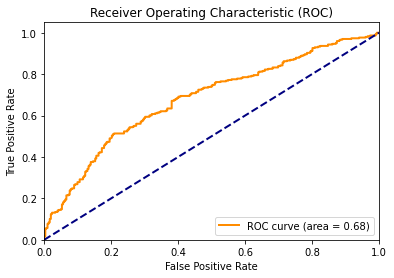

Metrics saved successfully


In [22]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_2000_epoch_100_metrics.csv')
metrics={
    'Combination':['MobileNet+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_2000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [23]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=150, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - accuracy: 0.6321 - loss: 0.6406 - val_accuracy: 0.5643 - val_loss: 0.7115
Epoch 2/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step - accuracy: 0.5999 - loss: 0.6473 - val_accuracy: 0.6107 - val_loss: 0.6688
Epoch 3/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step - accuracy: 0.6152 - loss: 0.6520 - val_accuracy: 0.5107 - val_loss: 0.6891
Epoch 4/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step - accuracy: 0.5621 - loss: 0.6699 - val_accuracy: 0.6000 - val_loss: 0.6771
Epoch 5/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step - accuracy: 0.5754 - loss: 0.6525 - val_accuracy: 0.6000 - val_loss: 0.6724
Epoch 6/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step - accuracy: 0.5833 - loss: 0.6619 - val_accuracy: 0.5893 - val_loss: 0.6724
Epoch 7/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step - accuracy: 0.6124 - loss: 0.6422 - val_accuracy: 0.5250 - val_loss: 0.6958
Training Time: 52.29949402809143 seconds


Validation Loss: 0.6687644124031067
Validation Accuracy: 0.6107142567634583
Test Loss: 0.6397474408149719
Test Accuracy: 0.6683333516120911
Inference Time (Test set): 4.390188694000244 seconds
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.73      0.69       302
           1       0.69      0.60      0.64       298

    accuracy                           0.67       600
   macro avg       0.67      0.67      0.67       600
weighted avg       0.67      0.67      0.67       600

Confusion Matrix:
[[221  81]
 [118 180]]


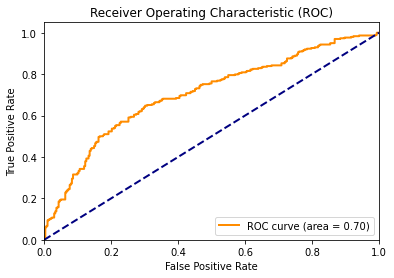

Metrics saved successfully


In [24]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_2000_epoch_150_metrics.csv')
metrics={
    'Combination':['MobileNet+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_2000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [25]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=200, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - accuracy: 0.6470 - loss: 0.6313 - val_accuracy: 0.5071 - val_loss: 0.7119
Epoch 2/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step - accuracy: 0.5730 - loss: 0.6691 - val_accuracy: 0.5964 - val_loss: 0.6766
Epoch 3/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 211ms/step - accuracy: 0.5947 - loss: 0.6586 - val_accuracy: 0.6357 - val_loss: 0.6635
Epoch 4/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step - accuracy: 0.6562 - loss: 0.6159 - val_accuracy: 0.6250 - val_loss: 0.6681
Epoch 5/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step - accuracy: 0.6302 - loss: 0.6282 - val_accuracy: 0.5929 - val_loss: 0.6722
Epoch 6/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step - accuracy: 0.6270 - loss: 0.6267 - val_accuracy: 0.5714 - val_loss: 0.6965
Epoch 7/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step - accuracy: 0.5820 - loss: 0.6719 - val_accuracy: 0.6393 - val_loss: 0.6585
Epoch 8/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step - accuracy: 0.6379 - loss: 0.6275 - val_accu

Validation Loss: 0.5976641178131104
Validation Accuracy: 0.7250000238418579
Test Loss: 0.5671074390411377
Test Accuracy: 0.7266666889190674
Inference Time (Test set): 4.363203048706055 seconds
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.69      0.72       302
           1       0.71      0.77      0.74       298

    accuracy                           0.73       600
   macro avg       0.73      0.73      0.73       600
weighted avg       0.73      0.73      0.73       600

Confusion Matrix:
[[208  94]
 [ 70 228]]


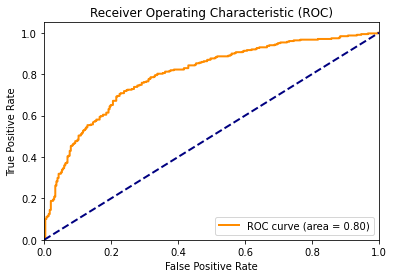

Metrics saved successfully


In [26]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_2000_epoch_200_metrics.csv')
metrics={
    'Combination':['MobileNet+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_2000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# MobileNet+Attention Mechanism+Dense

In [28]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate, Reshape, Permute, Multiply
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (224, 224, 3)

# Load MobileNet pre-trained on ImageNet without including the top (classification) layer
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add attention mechanism
attention_probs = Dense(1, activation='softmax')(base_model.output)
attention_mul = Multiply()([base_model.output, attention_probs])

# Add a global average pooling layer
x = GlobalAveragePooling2D()(attention_mul)

# Add a fully connected layer with 256 neurons
x = Dense(256, activation='relu')(x)

# Add the final classification layer with softmax activation
predictions = Dense(2, activation='softmax')(x)  # Assuming 2 classes: 'normal' and 'osteoarthritis'

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Preprocess the data
X_train_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_train)
X_val_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_val)
X_test_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_test)

# Convert labels to one-hot encoding
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Convert to one-hot encoding
y_train_categorical = to_categorical(y_train_encoded)
y_val_categorical = to_categorical(y_val_encoded)
y_test_categorical = to_categorical(y_test_encoded)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        128 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_1           │ (None, 112, 112,  │        288 │ conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_1_bn        │ (None, 112, 112,  │        128 │ conv_dw_1[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_1_relu      │ (None, 112, 112,  │          0 │ conv_dw_1_bn[0][… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_1 (Conv2D)  │ (None, 112, 112,  │      2,048 │ conv_dw_1_relu[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_1_bn        │ (None, 112, 112,  │        256 │ conv_pw_1[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_1_relu      │ (None, 112, 112,  │          0 │ conv_pw_1_bn[0][… │
│ (ReLU)              │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pad_2          │ (None, 113, 113,  │          0 │ conv_pw_1_relu[0… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_2           │ (None, 56, 56,    │        576 │ conv_pad_2[0][0]  │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_2_bn        │ (None, 56, 56,    │        256 │ conv_dw_2[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_2_relu      │ (None, 56, 56,    │          0 │ conv_dw_2_bn[0][… │
│ (ReLU)              │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_2 (Conv2D)  │ (None, 56, 56,    │      8,192 │ conv_dw_2_relu[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_2_bn        │ (None, 56, 56,    │        512 │ conv_pw_2[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_2_relu      │ (None, 56, 56,    │          0 │ conv_pw_2_bn[0][

 Total params: 3,492,803 (13.32 MB)

 Trainable params: 263,939 (1.01 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [29]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=50, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - accuracy: 0.4928 - loss: 0.7134 - val_accuracy: 0.4786 - val_loss: 0.7294
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 191ms/step - accuracy: 0.5259 - loss: 0.7011 - val_accuracy: 0.4786 - val_loss: 0.7060
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 191ms/step - accuracy: 0.4690 - loss: 0.7078 - val_accuracy: 0.4786 - val_loss: 0.6940
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 191ms/step - accuracy: 0.4656 - loss: 0.7151 - val_accuracy: 0.4786 - val_loss: 0.6944
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 191ms/step - accuracy: 0.4869 - loss: 0.7058 - val_accuracy: 0.5214 - val_loss: 0.6935
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 191ms/step - accuracy: 0.4769 - loss: 0.7147 - val_accuracy: 0.4786 - val_loss: 0.7120
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 191ms/step - accuracy: 0.4681 - loss: 0.7483 - val_accuracy: 0.4786 - val_loss: 0.7780
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 191ms/step - accuracy: 0.5043 - loss: 0.7254 - val_accuracy: 0.

Validation Loss: 0.6922913789749146
Validation Accuracy: 0.5214285850524902
Test Loss: 0.6940414309501648
Test Accuracy: 0.503333330154419
Inference Time (Test set): 4.31843638420105 seconds
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       302
           1       0.00      0.00      0.00       298

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.34       600

Confusion Matrix:
[[302   0]
 [298   0]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


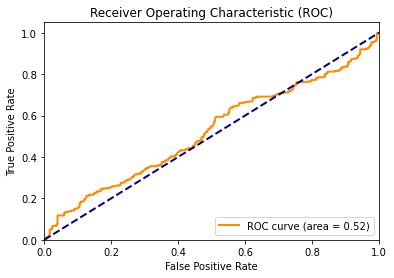

Metrics saved successfully


In [30]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_2000_epoch_50_metrics.csv')
metrics={
    'Combination':['MobileNet+Attention Mechanism +Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_2000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [31]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=100, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 197ms/step - accuracy: 0.4803 - loss: 0.6969 - val_accuracy: 0.5214 - val_loss: 0.6935
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.5040 - loss: 0.6986 - val_accuracy: 0.5214 - val_loss: 0.6954
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.5057 - loss: 0.7017 - val_accuracy: 0.4786 - val_loss: 0.7219
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.4323 - loss: 0.7277 - val_accuracy: 0.4786 - val_loss: 0.7314
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.4694 - loss: 0.7170 - val_accuracy: 0.5214 - val_loss: 0.6948
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.4974 - loss: 0.7024 - val_accuracy: 0.5214 - val_loss: 0.6928
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.5185 - loss: 0.6980 - val_accuracy: 0.4786 - val_loss: 0.6953
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.4907 - loss: 0.6970 - val_accu

Validation Loss: 0.6922985315322876
Validation Accuracy: 0.5214285850524902
Test Loss: 0.6936118006706238
Test Accuracy: 0.503333330154419
Inference Time (Test set): 4.294922590255737 seconds
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       302
           1       0.00      0.00      0.00       298

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.34       600

Confusion Matrix:
[[302   0]
 [298   0]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


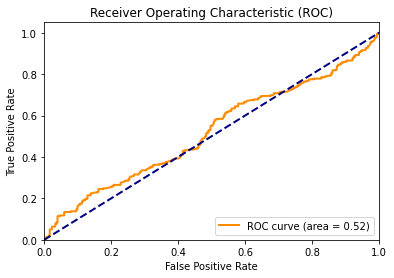

Metrics saved successfully


In [32]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_2000_epoch_100_metrics.csv')
metrics={
    'Combination':['MobileNet+Attention Mechanism +Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_2000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [33]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=150, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 197ms/step - accuracy: 0.4823 - loss: 0.6989 - val_accuracy: 0.5214 - val_loss: 0.6925
Epoch 2/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.4996 - loss: 0.6992 - val_accuracy: 0.5214 - val_loss: 0.6926
Epoch 3/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.5170 - loss: 0.6982 - val_accuracy: 0.5214 - val_loss: 0.6929
Epoch 4/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.4864 - loss: 0.6975 - val_accuracy: 0.5214 - val_loss: 0.6924
Epoch 5/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.5222 - loss: 0.6958 - val_accuracy: 0.5214 - val_loss: 0.7040
Epoch 6/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.4921 - loss: 0.7074 - val_accuracy: 0.5214 - val_loss: 0.6930
Epoch 7/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.5130 - loss: 0.6951 - val_accuracy: 0.4786 - val_loss: 0.7035
Epoch 8/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.4786 - loss: 0.7025 - val_accu

Validation Loss: 0.6924099922180176
Validation Accuracy: 0.5214285850524902
Test Loss: 0.6945701241493225
Test Accuracy: 0.503333330154419
Inference Time (Test set): 4.32479190826416 seconds
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       302
           1       0.00      0.00      0.00       298

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.34       600

Confusion Matrix:
[[302   0]
 [298   0]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


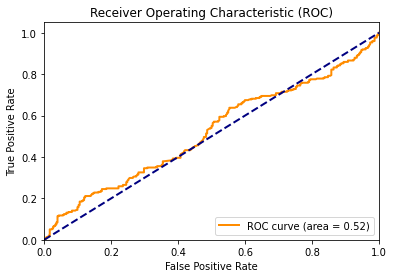

Metrics saved successfully


In [34]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_2000_epoch_150_metrics.csv')
metrics={
    'Combination':['MobileNet+Attention Mechanism +Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_2000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [35]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=200, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 197ms/step - accuracy: 0.5065 - loss: 0.6980 - val_accuracy: 0.5214 - val_loss: 0.6945
Epoch 2/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.4888 - loss: 0.6953 - val_accuracy: 0.4786 - val_loss: 0.7106
Epoch 3/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.5127 - loss: 0.6978 - val_accuracy: 0.4786 - val_loss: 0.7066
Epoch 4/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.5325 - loss: 0.6945 - val_accuracy: 0.4786 - val_loss: 0.6936
Epoch 5/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.4691 - loss: 0.6951 - val_accuracy: 0.5214 - val_loss: 0.6927
Epoch 6/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 196ms/step - accuracy: 0.4964 - loss: 0.6948 - val_accuracy: 0.5214 - val_loss: 0.6972
Epoch 7/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.4900 - loss: 0.7035 - val_accuracy: 0.5214 - val_loss: 0.6923
Epoch 8/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.4989 - loss: 0.6941 - val_accu

Validation Loss: 0.6922785043716431
Validation Accuracy: 0.5214285850524902
Test Loss: 0.6938332319259644
Test Accuracy: 0.503333330154419
Inference Time (Test set): 4.3108320236206055 seconds
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       302
           1       0.00      0.00      0.00       298

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.34       600

Confusion Matrix:
[[302   0]
 [298   0]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


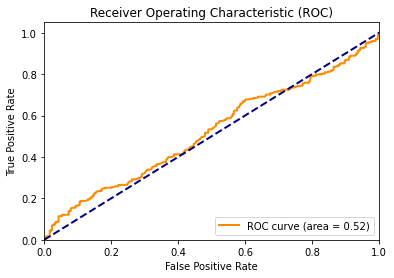

Metrics saved successfully


In [36]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_2000_epoch_200_metrics.csv')
metrics={
    'Combination':['MobileNet+Attention Mechanism +Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_2000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# MobileNet+Capsule Network+Dense

In [40]:
import tensorflow as tf
import numpy as np
import cv2
import time
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_score, recall_score, f1_score, cohen_kappa_score, matthews_corrcoef, balanced_accuracy_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Layer, GlobalAveragePooling2D, Reshape, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet
import pandas as pd

# Start time
start_time = time.time()

# Assume X_train, X_test, y_train, y_test are available

# Modify the data shapes based on the model requirements
X_train_resized = np.array([cv2.resize(img, (224, 224)) for img in X_train])
X_train_resized = np.expand_dims(X_train_resized, axis=-1)  # Add channel dimension
X_train_resized = np.repeat(X_train_resized, 3, axis=-1)  # Repeat the channel dimension to match the expected input shape of MobileNet

X_test_resized = np.array([cv2.resize(img, (224, 224)) for img in X_test])
X_test_resized = np.expand_dims(X_test_resized, axis=-1)
X_test_resized = np.repeat(X_test_resized, 3, axis=-1)

# Define Capsule Layer
class CapsuleLayer(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        self.W = self.add_weight(shape=[input_dim_capsule, self.num_capsule * self.dim_capsule],
                                 initializer='glorot_uniform',
                                 name='W')

    def call(self, u_vecs):
        u_hat_vecs = tf.reduce_sum(tf.expand_dims(u_vecs, -1) * tf.expand_dims(self.W, 0), axis=-2)
        b = tf.zeros(shape=[tf.shape(u_hat_vecs)[0], self.num_capsule])
        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=1)
            s_j = tf.reduce_sum(tf.multiply(c[:, :, None], u_hat_vecs), axis=1)
            v_j = self.squash(s_j)
            if i < self.routings - 1:
                b += tf.reduce_sum(tf.multiply(v_j[:, None, :], u_hat_vecs), axis=-1)
        return v_j

    def squash(self, s_j):
        s_squared_norm = tf.reduce_sum(tf.square(s_j), axis=-1, keepdims=True)
        scale = s_squared_norm / (1 + s_squared_norm) / tf.sqrt(s_squared_norm + tf.keras.backend.epsilon())
        return scale * s_j


# Load pre-trained MobileNet model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add Capsule Network
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Reshape((-1, 1024))(x)  # Reshape to 3D tensor for Capsule Network
x = CapsuleLayer(num_capsule=10, dim_capsule=16, routings=3)(x)  # Example: 10 capsules with dimension 16
x = Flatten()(x)  # Flatten the output
x = Dense(128, activation='relu')(x)
output = Dense(2, activation='softmax')(x)  # Use softmax activation for multi-class classification

# Create the full model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model with Adam optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()




Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,413,570 (13.02 MB)

 Trainable params: 184,706 (721.51 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [41]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=50, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 202ms/step - accuracy: 0.5000 - loss: 0.7003 - val_accuracy: 0.5214 - val_loss: 0.6926
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 193ms/step - accuracy: 0.5104 - loss: 0.6941 - val_accuracy: 0.4786 - val_loss: 0.6961
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 192ms/step - accuracy: 0.4520 - loss: 0.6951 - val_accuracy: 0.4786 - val_loss: 0.6932
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 192ms/step - accuracy: 0.5204 - loss: 0.6936 - val_accuracy: 0.5214 - val_loss: 0.6924
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 191ms/step - accuracy: 0.5040 - loss: 0.6951 - val_accuracy: 0.5214 - val_loss: 0.6923
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 190ms/step - accuracy: 0.4948 - loss: 0.6946 - val_accuracy: 0.4786 - val_loss: 0.6936
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 191ms/step - accuracy: 0.4969 - loss: 0.6943 - val_accuracy: 0.4786 - val_loss: 0.6955
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 191ms/step - accuracy: 0.4966 - loss: 0.6943 - val_accuracy: 0.

Validation Loss: 0.6922786235809326
Validation Accuracy: 0.5214285850524902
Test Loss: 0.69383305311203
Test Accuracy: 0.503333330154419
Inference Time (Test set): 4.264984369277954 seconds
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       302
           1       0.00      0.00      0.00       298

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.34       600

Confusion Matrix:
[[302   0]
 [298   0]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


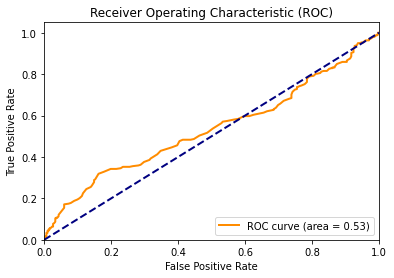

Metrics saved successfully


In [42]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_2000_epoch_50_metrics.csv')
metrics={
    'Combination':['MobileNet+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_2000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [43]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=100, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 192ms/step - accuracy: 0.4714 - loss: 0.6959 - val_accuracy: 0.5214 - val_loss: 0.6923
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 193ms/step - accuracy: 0.4961 - loss: 0.6938 - val_accuracy: 0.4786 - val_loss: 0.6938
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.4939 - loss: 0.6945 - val_accuracy: 0.4786 - val_loss: 0.6951
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.4994 - loss: 0.6941 - val_accuracy: 0.4786 - val_loss: 0.6940
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.5215 - loss: 0.6931 - val_accuracy: 0.5214 - val_loss: 0.6927
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.4675 - loss: 0.6942 - val_accuracy: 0.5214 - val_loss: 0.6929
Training Time: 40.9823522567749 seconds


Validation Loss: 0.6923022270202637
Validation Accuracy: 0.5214285850524902
Test Loss: 0.6936007142066956
Test Accuracy: 0.503333330154419
Inference Time (Test set): 4.36769700050354 seconds
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       302
           1       0.00      0.00      0.00       298

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.34       600

Confusion Matrix:
[[302   0]
 [298   0]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


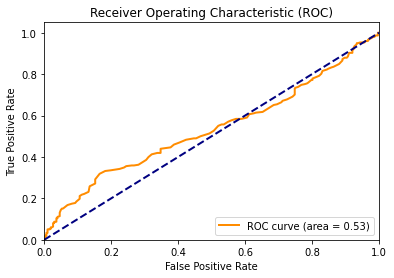

Metrics saved successfully


In [44]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_2000_epoch_100_metrics.csv')
metrics={
    'Combination':['MobileNet+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_2000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [45]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=150, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 197ms/step - accuracy: 0.4955 - loss: 0.6936 - val_accuracy: 0.4786 - val_loss: 0.6933
Epoch 2/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.4768 - loss: 0.6935 - val_accuracy: 0.5214 - val_loss: 0.6926
Epoch 3/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.5015 - loss: 0.6938 - val_accuracy: 0.4786 - val_loss: 0.6941
Epoch 4/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.5143 - loss: 0.6930 - val_accuracy: 0.5214 - val_loss: 0.6928
Epoch 5/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.4848 - loss: 0.6939 - val_accuracy: 0.4786 - val_loss: 0.6945
Epoch 6/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.5111 - loss: 0.6931 - val_accuracy: 0.4786 - val_loss: 0.6944
Epoch 7/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.5099 - loss: 0.6928 - val_accuracy: 0.4786 - val_loss: 0.6937
Training Time: 48.70697855949402 seconds


Validation Loss: 0.6926190853118896
Validation Accuracy: 0.5214285850524902
Test Loss: 0.6932000517845154
Test Accuracy: 0.503333330154419
Inference Time (Test set): 4.532019376754761 seconds
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       302
           1       0.00      0.00      0.00       298

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.34       600

Confusion Matrix:
[[302   0]
 [298   0]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


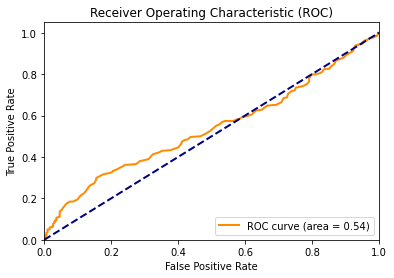

Metrics saved successfully


In [46]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_2000_epoch_150_metrics.csv')
metrics={
    'Combination':['MobileNet+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_2000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [ ]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=200, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 200ms/step - accuracy: 0.5045 - loss: 0.6948 - val_accuracy: 0.5214 - val_loss: 0.6927
Epoch 2/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 197ms/step - accuracy: 0.5143 - loss: 0.6935 - val_accuracy: 0.5214 - val_loss: 0.6929
Epoch 3/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step - accuracy: 0.5470 - loss: 0.6962 - val_accuracy: 0.4786 - val_loss: 0.6953
Epoch 4/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step - accuracy: 0.5186 - loss: 0.6934 - val_accuracy: 0.5214 - val_loss: 0.6926
Epoch 5/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step - accuracy: 0.5072 - loss: 0.6933 - val_accuracy: 0.4786 - val_loss: 0.6955
Epoch 6/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step - accuracy: 0.5101 - loss: 0.6935 - val_accuracy: 0.5214 - val_loss: 0.6928
Epoch 7/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step - accuracy: 0.5110 - loss: 0.6931 - val_accuracy: 0.4786 - val_loss: 0.6945
Epoch 8/200
15/35 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.5490 - loss: 0.6906

In [ ]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_2000_epoch_200_metrics.csv')
metrics={
    'Combination':['MobileNet+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_2000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")